### state

In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_at_state_hpi():
    df=pd.read_csv("../input/third2/HPI_AT_BDL_state.csv", dtype={'FIPS':np.str})
    df=df[df['Abbreviation'].isin({'IA','CA','NY','NC','OH'})]
    df=df[df.Year>1990]
    df['HPI']=df['HPI'].astype(np.float32)
    df=df[[u'State', u'Abbreviation', u'FIPS', u'Year' ,           u'HPI' ]]
    assert df.Abbreviation.value_counts().value_counts().shape[0]==1
    return df

In [3]:
state_hpi=read_at_state_hpi()

In [4]:
state_hpi.head()

State Abbreviation FIPS  Year         HPI
188  California           CA   06  1991  468.309998
189  California           CA   06  1992  460.299988
190  California           CA   06  1993  436.470001
191  California           CA   06  1994  423.140015
192  California           CA   06  1995  412.130005

In [5]:
state_hpi.Abbreviation.value_counts().value_counts()

27    5
Name: Abbreviation, dtype: int64

In [6]:
state_hpi.Year.max()

2017

In [7]:
pv_state_hpi=pd.pivot_table(state_hpi, columns='Year',values='HPI', index=['FIPS'])

In [8]:
pv_state_hpi

Year        1991        1992        1993        1994        1995        1996  \
FIPS                                                                           
06    468.309998  460.299988  436.470001  423.140015  412.130005  411.760010   
19    195.240005  201.339996  210.960007  223.179993  237.820007  246.850006   
36    323.029999  326.510010  325.750000  320.160004  319.459991  324.549988   
37    237.330002  241.270004  245.149994  254.589996  268.869995  279.640015   
39    225.169998  232.100006  239.279999  249.020004  261.950012  273.040009   

Year        1997        1998        1999        2000     ...             2008  \
FIPS                                                     ...                    
06    423.269989  456.869995  488.010010  555.979980     ...       951.250000   
19    256.549988  267.149994  277.480011  290.850006     ...       365.070007   
36    328.000000  341.429993  359.570007  399.070007     ...       659.299988   
37    292.790009  303.179993  313.859985  328.380005     ...       438.029999   
39    284.679993  294.519989  304.700012  318.769989     ...       356.260010   

Year        2009        2010        2011        2012        2013        2014  \
FIPS                                                                           
06    807.229980  781.159973  736.280029  731.059998  810.760010  925.679993   
19    362.750000  358.679993  356.320007  357.339996  362.019989  369.989990   
36    621.880005  602.770020  588.669983  574.570007  578.809998  593.469971   
37    424.380005  401.290009  386.040009  375.880005  379.049988  388.839996   
39    344.720001  332.510010  320.179993  314.380005  315.149994  325.070007   

Year        2015         2016         2017  
FIPS                                        
06    975.679993  1050.150024  1129.219971  
19    379.079987   392.119995   408.589996  
36    610.200012   631.059998   659.369995  
37    403.239990   421.859985   444.549988  
39    335.970001   349.089996   366.290009  

[5 rows x 27 columns]

In [9]:
from scipy import interpolate

In [10]:
lst=[]
for i in pv_state_hpi.index:
    print i,
    f = interpolate.interp1d(pv_state_hpi.columns, pv_state_hpi.loc[i],kind='slinear',
                             bounds_error=False,fill_value='extrapolate')
    lst.append(f([2018])[0])
pv_state_hpi.loc[:,2018]=lst

06 19 36 37 39


In [11]:
pv_state_hpi.to_csv("../input/third2/HPI_AT_BDL_5state.csv")

06


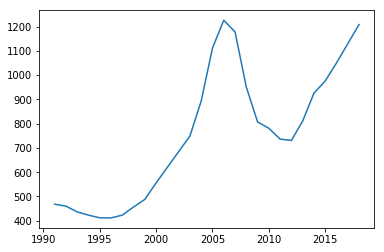

19


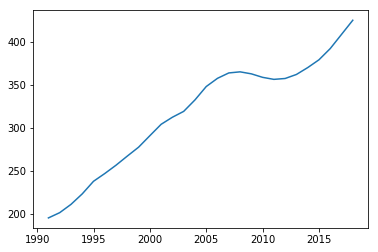

36


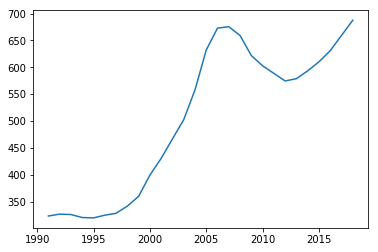

37


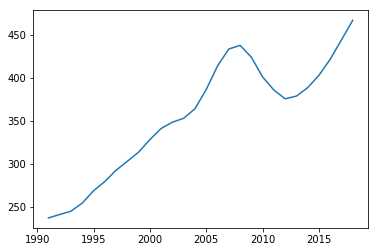

39


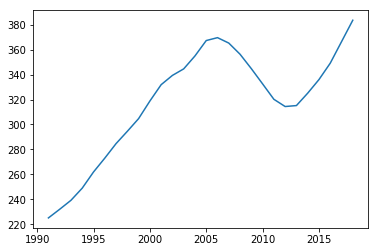

In [12]:
for i in pv_state_hpi.index:
    print i
    plt.plot(pv_state_hpi.loc[i])
    plt.show()

### zip3

In [13]:
%reset -f

In [14]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [15]:
pv_state_hpi=pd.read_csv("../input/third2/HPI_AT_BDL_5state.csv", dtype={'FIPS':np.str}).set_index("FIPS")

In [16]:
def get_state_yearly_hpi(state,year):
    return pv_state_hp.loc[state,year]

In [17]:
def read_zip3_to_state():
    zip_block=dd.read_parquet("../input/info/censusblockinfo_with_zip.parq").compute()
    zip_block['zip3']=zip_block['zip'].map(lambda u: u[:3])
    a=zip_block[['zip3','state']].drop_duplicates()
    assert a.groupby("zip3").count().state.value_counts().shape[0]==1
    return dict(a.values)

In [18]:
zip3_to_state=read_zip3_to_state()
len(zip3_to_state)

242

In [19]:
!head ../input/third2/HPI_AT_BDL_ZIP3.csv

In [20]:
def read_at_zip3_hpi():
    df=pd.read_csv("../input/third2/HPI_AT_BDL_ZIP3.csv", dtype={'Three-Digit ZIP Code':np.str})
    df['zip3']=df['Three-Digit ZIP Code']
    df=df[df['zip3'].isin(set(zip3_to_state.keys()))]
    df=df[df.Year>1990]
    df=df[[u'zip3',  u'Year' ,
       u'HPI' ]]
    df.loc[df['HPI']=='.',"HPI"]=np.nan
    df['HPI']=df['HPI'].astype(np.float32)
    return df

In [21]:
zip3_hpi=read_at_zip3_hpi()

In [22]:
zip3_hpi.tail()

zip3  Year         HPI
34022  976  2013  315.109985
34023  976  2014  325.239990
34024  976  2015  341.529999
34025  976  2016  354.809998
34026  976  2017  381.040009

In [23]:
zip3_hpi.Year.max(),zip3_hpi.Year.min()

(2017, 1991)

In [24]:
pv_zip3_hpi=pd.pivot_table(zip3_hpi, columns='Year',values='HPI', index=['zip3'])

In [25]:
pv_zip3_hpi.head()

Year        1991        1992        1993        1994        1995        1996  \
zip3                                                                           
028   361.480011  352.589996  349.570007  344.410004  344.570007  347.140015   
054   299.579987  300.119995  302.630005  305.369995  308.769989  311.399994   
057   183.110001  179.479996  177.789993  173.979996  172.740005  175.470001   
063   222.460007  214.729996  209.449997  204.679993  206.619995  212.279999   
068   356.910004  360.029999  358.760010  361.079987  369.839996  375.720001   

Year        1997        1998        1999        2000     ...            2008  \
zip3                                                     ...                   
028   350.529999  360.399994  375.799988  421.109985     ...      751.989990   
054   316.119995  321.640015  336.010010  369.000000     ...      613.919983   
057   174.970001  179.520004  184.139999  194.089996     ...      322.190002   
063   216.279999  221.699997  230.389999  249.130005     ...      411.649994   
068   387.200012  407.709991  434.700012  488.679993     ...      782.789978   

Year        2009        2010        2011        2012        2013        2014  \
zip3                                                                           
028   682.059998  649.140015  621.179993  600.090027  601.840027  616.739990   
054   597.330017  593.940002  593.309998  594.599976  597.400024  609.239990   
057   310.429993  299.570007  287.910004  287.029999  280.940002  276.450012   
063   382.029999  361.850006  346.750000  330.399994  321.179993  323.059998   
068   716.789978  684.099976  664.599976  651.900024  651.969971  662.380005   

Year        2015        2016        2017  
zip3                                      
028   641.349976  671.409973  712.739990  
054   621.309998  632.320007  650.679993  
057   276.480011  279.540009  284.510010  
063   324.820007  328.790009  341.899994  
068   677.380005  680.049988  684.020020  

[5 rows x 27 columns]

In [26]:
from scipy import interpolate
def f(df):
    lst=[]
    for i in df.index:
        print i,
        f = interpolate.interp1d(df.columns, df.loc[i],kind='slinear',
                                 bounds_error=False,fill_value='extrapolate')
        lst.append(f([2018])[0])
    df.loc[:,2018]=lst
    return df
pv_zip3_hpi=f(pv_zip3_hpi)

028 054 057 063 068 070 072 074 076 100 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 163 167 183 184 234 238 239 240 243 245 252 255 257 260 261 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 293 295 296 297 305 373 376 377 410 411 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 473 481 492 500 501 502 503 504 505 506 507 508 510 511 512 513 514 515 516 520 521 522 523 524 525 526 527 528 538 546 559 560 561 570 571 610 612 614 634 635 644 680 681 684 687 853 864 890 894 895 900 902 903 904 905 906 907 908 910 911 912 913 914 915 916 917 918 919 920 921 922 923 924 925 926 927 928 930 931 932 933 934 935 936 937 939 940 941 943 944 945 946 947 948 949 950 951 952 953 954 955 956 957 958 959 960 961 975 976


In [27]:
pv_zip3_hpi.head()

Year        1991        1992        1993        1994        1995        1996  \
zip3                                                                           
028   361.480011  352.589996  349.570007  344.410004  344.570007  347.140015   
054   299.579987  300.119995  302.630005  305.369995  308.769989  311.399994   
057   183.110001  179.479996  177.789993  173.979996  172.740005  175.470001   
063   222.460007  214.729996  209.449997  204.679993  206.619995  212.279999   
068   356.910004  360.029999  358.760010  361.079987  369.839996  375.720001   

Year        1997        1998        1999        2000     ...            2009  \
zip3                                                     ...                   
028   350.529999  360.399994  375.799988  421.109985     ...      682.059998   
054   316.119995  321.640015  336.010010  369.000000     ...      597.330017   
057   174.970001  179.520004  184.139999  194.089996     ...      310.429993   
063   216.279999  221.699997  230.389999  249.130005     ...      382.029999   
068   387.200012  407.709991  434.700012  488.679993     ...      716.789978   

Year        2010        2011        2012        2013        2014        2015  \
zip3                                                                           
028   649.140015  621.179993  600.090027  601.840027  616.739990  641.349976   
054   593.940002  593.309998  594.599976  597.400024  609.239990  621.309998   
057   299.570007  287.910004  287.029999  280.940002  276.450012  276.480011   
063   361.850006  346.750000  330.399994  321.179993  323.059998  324.820007   
068   684.099976  664.599976  651.900024  651.969971  662.380005  677.380005   

Year        2016        2017        2018  
zip3                                      
028   671.409973  712.739990  754.070007  
054   632.320007  650.679993  669.039978  
057   279.540009  284.510010  289.480011  
063   328.790009  341.899994  355.009979  
068   680.049988  684.020020  687.990051  

[5 rows x 28 columns]

In [28]:
pv_zip3_hpi[pv_zip3_hpi.isnull().sum(1)>10]

Year  1991  1992  1993  1994  1995  1996  1997   1998       1999        2000  \
zip3                                                                           
100    NaN   NaN   NaN   NaN   NaN   NaN   NaN  100.0  98.300003  105.790001   

Year  ...     2009  2010        2011        2012  2013  2014  2015  2016  \
zip3  ...                                                                  
100   ...   256.25   NaN  271.029999  290.230011   NaN   NaN   NaN   NaN   

Year  2017  2018  
zip3              
100    NaN   NaN  

[1 rows x 28 columns]

In [29]:
pv_zip3_hpi[pv_zip3_hpi.isnull().sum(1)>0].isnull().sum(1).max(),len(pv_zip3_hpi[pv_zip3_hpi.isnull().sum(1)>0])

(14, 6)

In [30]:
pv_zip3_hpi[pv_zip3_hpi.isnull().sum(1)>0].head()

Year  1991   1992        1993    1994        1995        1996        1997  \
zip3                                                                        
100    NaN    NaN         NaN     NaN         NaN         NaN         NaN   
167    NaN    NaN         NaN     NaN         NaN         NaN         NaN   
289    NaN    NaN         NaN     NaN         NaN         NaN  100.000000   
508    NaN    NaN         NaN     NaN         NaN  100.000000  108.290001   
516    NaN  100.0  100.470001  104.75  122.989998  127.720001  122.750000   

Year        1998        1999        2000     ...            2009        2010  \
zip3                                         ...                               
100   100.000000   98.300003  105.790001     ...      256.250000         NaN   
167          NaN         NaN         NaN     ...      109.529999  109.589996   
289    99.559998  104.300003  113.059998     ...      170.289993  148.800003   
508   107.699997  115.349998  114.169998     ...      148.119995  143.559998   
516   142.729996  140.449997  147.259995     ...      174.059998  178.490005   

Year        2011        2012        2013        2014        2015        2016  \
zip3                                                                           
100   271.029999  290.230011         NaN         NaN         NaN         NaN   
167   112.889999  114.800003  115.320000  109.879997  104.889999  119.169998   
289   137.410004  128.559998  124.459999  122.260002  129.339996  137.070007   
508   142.529999  139.330002  146.820007  160.710007  149.399994  150.759995   
516   170.330002  171.580002  175.580002  175.089996  178.009995  170.889999   

Year        2017        2018  
zip3                          
100          NaN         NaN  
167   111.029999  102.889999  
289   140.979996  144.889984  
508   166.419998  182.080002  
516   181.100006  191.310013  

[5 rows x 28 columns]

In [31]:
def interpolate(county_hpi, state_hpi,beta=500):
    if np.isnan(county_hpi).sum()==0:
        return county_hpi
    assert len(county_hpi)==len(state_hpi)
    assert np.isnan(state_hpi).sum()==0
    
    n=len(county_hpi)
    A=np.zeros(shape=[n-1,n])
    for i in range(n-1):
        A[i,i]=-1
        A[i,i+1]=1
    A=np.asmatrix(A)
    B=np.asmatrix(np.diag(~np.isnan(county_hpi)).astype(np.float))
    C= np.diag(np.isnan(np.diff(county_hpi) ).astype(np.float))
    D=C*A
    BTB=B.T*B
    DTD=D.T*D
    
    E=beta*BTB+DTD
    
    v=county_hpi.copy()
    v[np.isnan(v)]=1.0
    v=np.asmatrix(np.log(v).reshape([-1,1]))
    u=np.asmatrix(np.log(state_hpi).reshape([-1,1]))
    b=beta*BTB*v+DTD*u
    #print n,A.shape,b.shape,C.shape, D.shape, BTB.shape,DTD.shape, E.shape,b.shape
    
    r=np.linalg.pinv(E)*b
    r=np.asarray(r)[:,0]
    r=np.exp(r)
    #display(pd.DataFrame(np.array([r,county_hpi,state_hpi])))
    #display(pd.DataFrame(np.array([r,county_hpi,state_hpi])).diff(axis=1))

    return  r, np.sqrt(np.nansum((r-county_hpi)**2).sum())/np.nanmean(county_hpi)

In [32]:
b=pv_state_hpi.loc['36'].values
a=pv_zip3_hpi.loc['100'].values


In [33]:
interpolate(a,b,500)

(array([ 94.61090121,  95.63014381,  95.4075506 ,  93.77031895,
         93.56529889,  95.05608763,  96.06654365, 100.        ,
         98.30000305, 105.79000092, 126.29000092, 144.36000061,
        150.27000427, 178.36000061, 143.8999939 , 207.25      ,
        250.1499939 , 251.02999878, 256.27837765, 262.54454612,
        270.99998769, 290.23001099, 292.37174349, 299.77688466,
        308.2276358 , 318.76455564, 333.06466113, 347.36476292]),
 0.00022471742825640339)

In [34]:
def fillna_zip3_yearly_hpi():
    new_pv_zip3_hpi=pv_zip3_hpi.copy()
    for code in pv_zip3_hpi[pv_zip3_hpi.isnull().sum(1)>0].index:
        row = pv_zip3_hpi.loc[code]
        state_hpi=pv_state_hpi.loc[zip3_to_state[code]]
        #print row,state_hpi
        estimate,error= interpolate(row.values,state_hpi.values)
        print code, "%Error=", np.round(error,4)
        for i in np.where(np.isnan(row.values)):
            year=row.index[i]
            assert np.isnan(new_pv_zip3_hpi.loc[code,year]).all()
            new_pv_zip3_hpi.loc[code,year]=estimate[i]
    return new_pv_zip3_hpi
new_pv_zip3_hpi=fillna_zip3_yearly_hpi()

100 %Error= 0.0002
167 %Error= 0.0
289 %Error= 0.0
508 %Error= 0.0
516 %Error= 0.0
521 %Error= 0.0


In [35]:
(new_pv_zip3_hpi-pv_zip3_hpi)[pv_zip3_hpi.isnull().sum(1)>0].head()

Year  1991  1992  1993  1994  1995  1996  1997  1998  1999  2000  ...   2009  \
zip3                                                              ...          
100    NaN   NaN   NaN   NaN   NaN   NaN   NaN   0.0   0.0   0.0  ...    0.0   
167    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    0.0   
289    NaN   NaN   NaN   NaN   NaN   NaN   0.0   0.0   0.0   0.0  ...    0.0   
508    NaN   NaN   NaN   NaN   NaN   0.0   0.0   0.0   0.0   0.0  ...    0.0   
516    NaN   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   

Year  2010  2011  2012  2013  2014  2015  2016  2017  2018  
zip3                                                        
100    NaN   0.0   0.0   NaN   NaN   NaN   NaN   NaN   NaN  
167    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
289    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
508    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
516    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 28 columns]

In [36]:
(new_pv_zip3_hpi)[pv_zip3_hpi.isnull().sum(1)>0].head()

Year       1991        1992        1993        1994        1995        1996  \
zip3                                                                          
100   94.610901   95.630142   95.407547   93.770317   93.565300   95.056091   
167   75.072624   75.881386   75.704758   74.405632   74.242950   75.425873   
289   81.058098   82.403770   83.728951   86.953110   91.830322   95.508728   
508   79.092567   81.563705   85.460808   90.411179   96.341911  100.000000   
516   96.970299  100.000000  100.470001  104.750000  122.989998  127.720001   

Year        1997        1998        1999        2000     ...            2009  \
zip3                                                     ...                   
100    96.066544  100.000000   98.300003  105.790001     ...      256.250000   
167    76.227661   79.348808   83.564575   92.744431     ...      109.529999   
289   100.000000   99.559998  104.300003  113.059998     ...      170.289993   
508   108.290001  107.699997  115.349998  114.169998     ...      148.119995   
516   122.750000  142.729996  140.449997  147.259995     ...      174.059998   

Year        2010        2011        2012        2013        2014        2015  \
zip3                                                                           
100   262.544556  271.029999  290.230011  292.371735  299.776886  308.227631   
167   109.589996  112.889999  114.800003  115.320000  109.879997  104.889999   
289   148.800003  137.410004  128.559998  124.459999  122.260002  129.339996   
508   143.559998  142.529999  139.330002  146.820007  160.710007  149.399994   
516   178.490005  170.330002  171.580002  175.580002  175.089996  178.009995   

Year        2016        2017        2018  
zip3                                      
100   318.764557  333.064667  347.364763  
167   119.169998  111.029999  102.889999  
289   137.070007  140.979996  144.889984  
508   150.759995  166.419998  182.080002  
516   170.889999  181.100006  191.310013  

[5 rows x 28 columns]

100


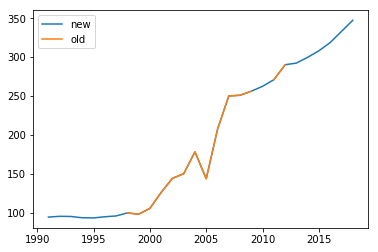

167


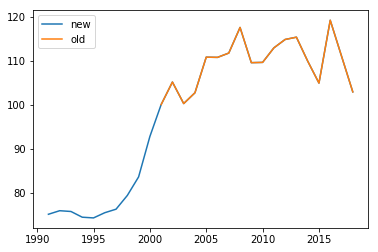

289


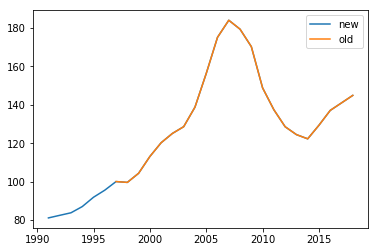

508


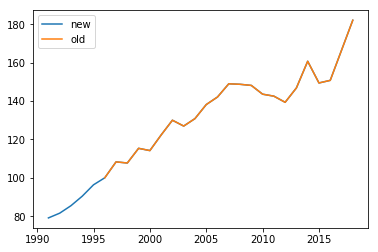

516


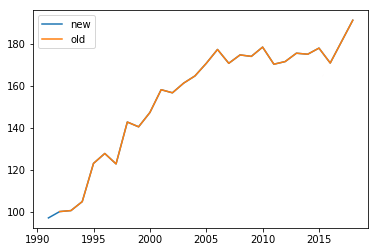

521


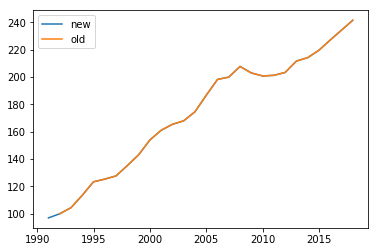

In [37]:
for i in  (new_pv_zip3_hpi)[pv_zip3_hpi.isnull().sum(1)>0].index:
    print i
    plt.plot(new_pv_zip3_hpi.loc[i])
    plt.plot(pv_zip3_hpi.loc[i])    
    plt.legend(['new','old'])
    plt.show()

In [38]:
new_pv_zip3_hpi.to_csv("../input/third2/HPI_AT_BDL_zip3_5state.csv")

### zip5

In [39]:
%reset -f

In [40]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [41]:
pv_zip3_hpi=pd.read_csv("../input/third2/HPI_AT_BDL_zip3_5state.csv", dtype={'zip3':np.str}).set_index("zip3")

In [42]:
def get_zip3_yearly_hpi(zip3,year):
    return pv_zip3_hpi.loc[zip3,year]

In [43]:
def read_zip5_to_state():
    zip_block=dd.read_parquet("../input/info/censusblockinfo_with_zip.parq").compute()
    a=zip_block[['zip','state']].drop_duplicates()
    assert a.groupby("zip").count().state.value_counts().shape[0]==1
    return dict(a.values)

In [44]:
zip5_to_state=read_zip5_to_state()
len(zip5_to_state)

6683

In [45]:
!head ../input/third2/HPI_AT_BDL_ZIP5.csv

In [46]:
def read_at_zip5_hpi():
    df=pd.read_csv("../input/third2/HPI_AT_BDL_ZIP5.csv", dtype={'Five-Digit ZIP Code':np.str})
    df['zip5']=df['Five-Digit ZIP Code']
    df=df[df['zip5'].isin(set(zip5_to_state.keys()))]
    df=df[df.Year>1990]
    df=df[[u'zip5',  u'Year' ,
       u'HPI' ]]
    df.loc[df['HPI']=='.',"HPI"]=np.nan
    df['HPI']=df['HPI'].astype(np.float32)
    return df

In [47]:
zip5_hpi=read_at_zip5_hpi()

In [48]:
zip5_hpi.Year.max(),zip5_hpi.Year.min()

(2017, 1991)

In [49]:
pv_zip5_hpi=pd.pivot_table(zip5_hpi, columns='Year',values='HPI', index=['zip5'])

In [50]:
pv_zip5_hpi[pv_zip5_hpi.isnull().sum(1)>10].head()

Year   1991  1992  1993  1994  1995  1996  1997  1998  1999  2000     ...      \
zip5                                                                  ...       
05734   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN     ...       
05770   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN     ...       
10457   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN     ...       
10468   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN     ...       
10475   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN     ...       

Year         2008        2009        2010        2011        2012        2013  \
zip5                                                                            
05734  172.550003  180.899994  185.740005  163.649994  180.550003  199.839996   
05770  141.100006  140.389999  138.889999  134.779999  137.470001  131.940002   
10457  168.089996  153.279999  153.449997  143.660004  127.809998  124.919998   
10468  132.270004  125.180000  123.160004  101.989998  100.550003   96.480003   
10475  158.889999  148.649994  129.830002  126.410004  122.430000         NaN   

Year         2014  2015        2016        2017  
zip5                                             
05734  123.110001   NaN  197.110001  184.020004  
05770         NaN   NaN  143.169998         NaN  
10457         NaN   NaN         NaN  214.050003  
10468         NaN   NaN         NaN         NaN  
10475  111.860001   NaN         NaN         NaN  

[5 rows x 27 columns]

In [51]:
from scipy import interpolate
def f(df):
    lst=[]
    for i in df.index:
        print i,
        f = interpolate.interp1d(df.columns, df.loc[i],kind='slinear',
                                 bounds_error=False,fill_value='extrapolate')
        lst.append(f([2018])[0])
    df.loc[:,2018]=lst
    return df
pv_zip5_hpi=f(pv_zip5_hpi)

02891 05458 05734 05743 05764 05770 06853 07002 07008 07020 07036 07077 07086 07206 07418 07461 07645 10301 10302 10303 10304 10305 10306 10307 10308 10309 10310 10312 10314 10457 10461 10462 10463 10464 10465 10466 10467 10468 10469 10470 10471 10472 10473 10475 10501 10502 10504 10506 10507 10509 10510 10511 10512 10514 10516 10518 10520 10522 10523 10524 10526 10527 10528 10530 10532 10533 10536 10537 10538 10541 10543 10546 10547 10548 10549 10550 10552 10553 10560 10562 10566 10567 10570 10573 10576 10577 10578 10579 10580 10583 10588 10589 10590 10591 10594 10595 10596 10598 10603 10604 10605 10606 10607 10701 10703 10704 10705 10706 10707 10708 10709 10710 10801 10803 10804 10805 10901 10913 10916 10917 10918 10919 10920 10921 10923 10924 10925 10926 10927 10928 10930 10931 10940 10941 10950 10952 10954 10956 10958 10960 10962 10963 10964 10965 10968 10969 10970 10973 10974 10976 10977 10980 10983 10984 10986 10987 10989 10990 10992 10993 10994 10998 11001 11003 11004 11010 1102

 43988 44001 44003 44004 44010 44011 44012 44017 44021 44022 44023 44024 44026 44028 44030 44032 44035 44039 44040 44041 44044 44046 44047 44048 44050 44052 44053 44054 44055 44056 44057 44060 44062 44064 44065 44067 44070 44072 44074 44076 44077 44081 44084 44085 44086 44087 44089 44090 44092 44093 44094 44095 44099 44102 44103 44105 44106 44107 44108 44109 44110 44111 44112 44113 44116 44117 44118 44119 44120 44121 44122 44123 44124 44125 44126 44128 44129 44130 44131 44132 44133 44134 44135 44136 44137 44138 44139 44140 44141 44142 44143 44144 44145 44146 44147 44149 44201 44202 44203 44212 44214 44215 44216 44217 44221 44223 44224 44230 44231 44233 44234 44235 44236 44240 44241 44251 44253 44254 44255 44256 44260 44262 44264 44266 44270 44272 44273 44275 44276 44278 44280 44281 44286 44287 44288 44301 44302 44303 44305 44306 44307 44310 44311 44312 44313 44314 44319 44320 44321 44333 44401 44402 44403 44404 44405 44406 44408 44410 44411 44412 44413 44417 44418 44420 44423 44425 444

94115 94116 94117 94118 94121 94122 94123 94124 94127 94131 94132 94134 94301 94303 94305 94306 94401 94402 94403 94404 94501 94502 94503 94505 94506 94507 94508 94509 94510 94513 94515 94517 94518 94519 94520 94521 94523 94525 94526 94530 94531 94533 94534 94536 94538 94539 94541 94542 94544 94545 94546 94547 94549 94550 94551 94552 94553 94555 94556 94558 94559 94560 94561 94563 94564 94565 94566 94567 94568 94571 94572 94574 94577 94578 94579 94580 94582 94583 94585 94586 94587 94588 94589 94590 94591 94595 94596 94597 94598 94599 94601 94602 94603 94605 94606 94607 94608 94609 94610 94611 94618 94619 94621 94702 94703 94704 94705 94706 94707 94708 94709 94710 94801 94803 94804 94805 94806 94901 94903 94904 94920 94923 94924 94925 94928 94930 94931 94937 94939 94941 94945 94947 94949 94951 94952 94954 94957 94960 94965 95003 95004 95005 95006 95008 95010 95012 95014 95018 95019 95020 95023 95030 95032 95033 95035 95037 95045 95046 95050 95051 95054 95060 95062 95065 95066 95070 9507

In [52]:
pv_zip5_hpi[pv_zip5_hpi.isnull().sum(1)>0].isnull().sum(1).max(),len(pv_zip5_hpi[pv_zip5_hpi.isnull().sum(1)>0])

(24, 1631)

In [53]:
pv_zip5_hpi[pv_zip5_hpi.isnull().sum(1)>0].head()

Year   1991   1992        1993       1994       1995        1996        1997  \
zip5                                                                           
05458   NaN  100.0  101.639999  90.050003  98.349998  101.550003  100.809998   
05734   NaN    NaN         NaN        NaN        NaN         NaN         NaN   
05743   NaN  100.0   94.540001  85.540001  84.510002   88.739998   73.430000   
05764   NaN    NaN         NaN        NaN        NaN         NaN         NaN   
05770   NaN    NaN         NaN        NaN        NaN         NaN         NaN   

Year         1998        1999        2000     ...            2009        2010  \
zip5                                          ...                               
05458  107.949997  100.870003  118.870003     ...      215.860001  211.190002   
05734         NaN         NaN         NaN     ...      180.899994  185.740005   
05743   98.680000   92.080002   89.980003     ...      154.210007  147.949997   
05764         NaN  100.000000  106.120003     ...      176.009995  177.580002   
05770         NaN         NaN         NaN     ...      140.389999  138.889999   

Year         2011        2012        2013        2014        2015        2016  \
zip5                                                                            
05458  219.089996  220.789993  212.940002  205.839996  240.139999  225.619995   
05734  163.649994  180.550003  199.839996  123.110001         NaN  197.110001   
05743  162.690002  140.679993  151.550003  144.869995  157.389999  143.229996   
05764  158.350006  154.830002  152.339996  169.190002  145.809998  151.300003   
05770  134.779999  137.470001  131.940002         NaN         NaN  143.169998   

Year         2017        2018  
zip5                           
05458  228.259995  230.899994  
05734  184.020004  170.930008  
05743  145.789993  148.349991  
05764  130.110001  108.919998  
05770         NaN         NaN  

[5 rows x 28 columns]

In [54]:
def interpolate(county_hpi, state_hpi,beta=500):
    if np.isnan(county_hpi).sum()==0:
        return county_hpi
    assert len(county_hpi)==len(state_hpi)
    assert np.isnan(state_hpi).sum()==0
    
    n=len(county_hpi)
    A=np.zeros(shape=[n-1,n])
    for i in range(n-1):
        A[i,i]=-1
        A[i,i+1]=1
    A=np.asmatrix(A)
    B=np.asmatrix(np.diag(~np.isnan(county_hpi)).astype(np.float))
    C= np.diag(np.isnan(np.diff(county_hpi) ).astype(np.float))
    D=C*A
    BTB=B.T*B
    DTD=D.T*D
    
    E=beta*BTB+DTD
    
    v=county_hpi.copy()
    v[np.isnan(v)]=1.0
    v=np.asmatrix(np.log(v).reshape([-1,1]))
    u=np.asmatrix(np.log(state_hpi).reshape([-1,1]))
    b=beta*BTB*v+DTD*u
    #print n,A.shape,b.shape,C.shape, D.shape, BTB.shape,DTD.shape, E.shape,b.shape
    
    r=np.linalg.pinv(E)*b
    r=np.asarray(r)[:,0]
    r=np.exp(r)
    #display(pd.DataFrame(np.array([r,county_hpi,state_hpi])))
    #display(pd.DataFrame(np.array([r,county_hpi,state_hpi])).diff(axis=1))

    return  r, np.sqrt(np.nansum((r-county_hpi)**2).sum())/np.nanmean(county_hpi)

In [55]:
b=pv_zip3_hpi.loc['054'].values
a=pv_zip5_hpi.loc['05458'].values


In [56]:
interpolate(a,b,500)

(array([ 99.82007197, 100.        , 101.63999939,  90.05000305,
         98.34999847, 101.55000305, 100.80999756, 107.94999695,
        100.87000275, 118.87000275, 130.24000549, 140.74000549,
        147.41999817, 170.41000366, 187.69000244, 209.58999634,
        213.53999329, 217.42999268, 215.86000061, 211.19000244,
        219.08999634, 220.78999329, 212.94000244, 205.83999634,
        240.13999939, 225.61999512, 228.25999451, 230.8999939 ]),
 1.821283180208222e-15)

In [57]:
def fillna_zip5_yearly_hpi():
    new_pv_zip5_hpi=pv_zip5_hpi.copy()
    for code in pv_zip5_hpi[pv_zip5_hpi.isnull().sum(1)>0].index:
        row = pv_zip5_hpi.loc[code]
        state_hpi=pv_zip3_hpi.loc[code[:3]]
        #print row,state_hpi
        estimate,error= interpolate(row.values,state_hpi.values)
        print code, "%Error=", np.round(error,4)
        for i in np.where(np.isnan(row.values)):
            year=row.index[i]
            assert np.isnan(new_pv_zip5_hpi.loc[code,year]).all()
            new_pv_zip5_hpi.loc[code,year]=estimate[i]
    return new_pv_zip5_hpi
new_pv_zip5_hpi=fillna_zip5_yearly_hpi()

05458 %Error= 0.0
05734 %Error= 0.0007
05743 %Error= 0.0
05764 %Error= 0.0
05770 %Error= 0.0001
07020 %Error= 0.0
07206 %Error= 0.0001
07418 %Error= 0.0
10457 %Error= 0.0003
10467 %Error= 0.0
10468 %Error= 0.0
10471 %Error= 0.0
10472 %Error= 0.0
10475 %Error= 0.0001
10501 %Error= 0.0002
10506 %Error= 0.0
10507 %Error= 0.0
10511 %Error= 0.0
10518 %Error= 0.0002
10524 %Error= 0.0
10526 %Error= 0.0
10527 %Error= 0.0
10528 %Error= 0.0
10537 %Error= 0.0
10546 %Error= 0.0001
10560 %Error= 0.0
10576 %Error= 0.0
10577 %Error= 0.0004
10578 %Error= 0.0
10589 %Error= 0.0
10590 %Error= 0.0
10596 %Error= 0.0
10916 %Error= 0.0
10917 %Error= 0.0
10919 %Error= 0.0001
10925 %Error= 0.0
10928 %Error= 0.0
10931 %Error= 0.0
10958 %Error= 0.0
10963 %Error= 0.0
10964 %Error= 0.0001
10968 %Error= 0.0
10969 %Error= 0.0001
10973 %Error= 0.0
10976 %Error= 0.0
10986 %Error= 0.0
10987 %Error= 0.0
10998 %Error= 0.0
11096 %Error= 0.0
11103 %Error= 0.0
11104 %Error= 0.0
11105 %Error= 0.0
11213 %Error= 0.0
11219 %Err

27537 %Error= 0.0
27541 %Error= 0.0
27542 %Error= 0.0
27544 %Error= 0.0001
27546 %Error= 0.0
27549 %Error= 0.0
27551 %Error= 0.0
27557 %Error= 0.0
27559 %Error= 0.0
27560 %Error= 0.0
27562 %Error= 0.0
27569 %Error= 0.0
27571 %Error= 0.0
27573 %Error= 0.0
27574 %Error= 0.0
27576 %Error= 0.0
27581 %Error= 0.0
27583 %Error= 0.0
27601 %Error= 0.0
27617 %Error= 0.0
27807 %Error= 0.0
27808 %Error= 0.0
27809 %Error= 0.0
27810 %Error= 0.0
27814 %Error= 0.0001
27817 %Error= 0.0
27822 %Error= 0.0
27823 %Error= 0.0001
27828 %Error= 0.0
27830 %Error= 0.0
27837 %Error= 0.0
27842 %Error= 0.0
27850 %Error= 0.0
27851 %Error= 0.0
27855 %Error= 0.0
27863 %Error= 0.0
27880 %Error= 0.0
27882 %Error= 0.0
27891 %Error= 0.0
27892 %Error= 0.0
27910 %Error= 0.0
27921 %Error= 0.0
27927 %Error= 0.0
27929 %Error= 0.0
27932 %Error= 0.0
27937 %Error= 0.0001
27939 %Error= 0.0
27941 %Error= 0.0002
27944 %Error= 0.0
27950 %Error= 0.0
27954 %Error= 0.0
27958 %Error= 0.0
27962 %Error= 0.0003
27970 %Error= 0.0001
27973 %

44681 %Error= 0.0
44683 %Error= 0.0
44688 %Error= 0.0
44695 %Error= 0.0002
44802 %Error= 0.0
44804 %Error= 0.0
44807 %Error= 0.0001
44814 %Error= 0.0
44817 %Error= 0.0
44818 %Error= 0.0001
44822 %Error= 0.0
44824 %Error= 0.0
44826 %Error= 0.0
44836 %Error= 0.0
44837 %Error= 0.0
44840 %Error= 0.0
44841 %Error= 0.0001
44842 %Error= 0.0
44843 %Error= 0.0
44846 %Error= 0.0
44847 %Error= 0.0
44851 %Error= 0.0
44853 %Error= 0.0002
44854 %Error= 0.0
44855 %Error= 0.0002
44859 %Error= 0.0001
44864 %Error= 0.0
44865 %Error= 0.0001
44866 %Error= 0.0
44867 %Error= 0.0
44878 %Error= 0.0004
44880 %Error= 0.0001
44882 %Error= 0.0
44889 %Error= 0.0
44902 %Error= 0.0001
45003 %Error= 0.0002
45034 %Error= 0.0
45054 %Error= 0.0
45064 %Error= 0.0
45065 %Error= 0.0
45101 %Error= 0.0
45113 %Error= 0.0
45120 %Error= 0.0001
45121 %Error= 0.0
45123 %Error= 0.0
45130 %Error= 0.0
45135 %Error= 0.0
45142 %Error= 0.0
45144 %Error= 0.0
45146 %Error= 0.0
45148 %Error= 0.0
45153 %Error= 0.0001
45154 %Error= 0.0
4515

57049 %Error= 0.0
61074 %Error= 0.0
61256 %Error= 0.0
61259 %Error= 0.0001
68023 %Error= 0.0
68061 %Error= 0.0
68108 %Error= 0.0
85344 %Error= 0.0
89048 %Error= 0.0
89060 %Error= 0.0
89061 %Error= 0.0
89448 %Error= 0.0004
89449 %Error= 0.0002
90012 %Error= 0.0001
90015 %Error= 0.0003
90020 %Error= 0.0001
90024 %Error= 0.0
90028 %Error= 0.0
90049 %Error= 0.0
90057 %Error= 0.0
90211 %Error= 0.0
90212 %Error= 0.0004
90272 %Error= 0.0
90292 %Error= 0.0
90402 %Error= 0.0001
90403 %Error= 0.0001
90404 %Error= 0.0
91008 %Error= 0.0002
91101 %Error= 0.0
91502 %Error= 0.0001
91905 %Error= 0.0
91914 %Error= 0.0
91915 %Error= 0.0
91962 %Error= 0.0
92004 %Error= 0.0
92036 %Error= 0.0
92061 %Error= 0.0
92070 %Error= 0.0
92091 %Error= 0.0001
92101 %Error= 0.0001
92121 %Error= 0.0003
92225 %Error= 0.0
92236 %Error= 0.0
92241 %Error= 0.0
92249 %Error= 0.0
92250 %Error= 0.0
92274 %Error= 0.0
92276 %Error= 0.0
92277 %Error= 0.0
92315 %Error= 0.0006
92325 %Error= 0.0001
92339 %Error= 0.0
92342 %Error= 0.

In [58]:
(new_pv_zip5_hpi-pv_zip5_hpi)[pv_zip5_hpi.isnull().sum(1)>0].head()

Year   1991  1992  1993  1994  1995  1996  1997  1998  1999  2000  ...   2009  \
zip5                                                               ...          
05458   NaN   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
05734   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    0.0   
05743   NaN   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
05764   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   0.0   0.0  ...    0.0   
05770   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    0.0   

Year   2010  2011  2012  2013  2014  2015  2016  2017  2018  
zip5                                                         
05458   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
05734   0.0   0.0   0.0   0.0   0.0   NaN   0.0   0.0   0.0  
05743   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
05764   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
05770   0.0   0.0   0.0   0.0   NaN   NaN   0.0   NaN   NaN  

[5 rows x 28 columns]

In [59]:
(new_pv_zip5_hpi)[pv_zip5_hpi.isnull().sum(1)>0].head()

Year         1991        1992        1993       1994       1995        1996  \
zip5                                                                          
05458   99.820068  100.000000  101.639999  90.050003  98.349998  101.550003   
05734   88.694603   86.936302   86.117706  84.272224  83.671593   84.993942   
05743  102.022507  100.000000   94.540001  85.540001  84.510002   88.739998   
05764   99.440643   97.469315   96.551537  94.482460  93.809059   95.291626   
05770   79.478279   77.902687   77.169151  75.515427  74.977211   76.162163   

Year         1997        1998        1999        2000     ...            2009  \
zip5                                                      ...                   
05458  100.809998  107.949997  100.870003  118.870003     ...      215.860001   
05734   84.751755   86.955681   89.193512   94.013077     ...      180.899994   
05743   73.430000   98.680000   92.080002   89.980003     ...      154.210007   
05764   95.020096   97.491043  100.000000  106.120003     ...      176.009995   
05770   75.945137   77.920052   79.925346   84.244110     ...      140.389999   

Year         2010        2011        2012        2013        2014        2015  \
zip5                                                                            
05458  211.190002  219.089996  220.789993  212.940002  205.839996  240.139999   
05734  185.740005  163.649994  180.550003  199.839996  123.110001  154.929611   
05743  147.949997  162.690002  140.679993  151.550003  144.869995  157.389999   
05764  177.580002  158.350006  154.830002  152.339996  169.190002  145.809998   
05770  138.889999  134.779999  137.470001  131.940002  133.639923  137.567245   

Year         2016        2017        2018  
zip5                                       
05458  225.619995  228.259995  230.899994  
05734  197.110001  184.020004  170.930008  
05743  143.229996  145.789993  148.349991  
05764  151.300003  130.110001  108.919998  
05770  143.169998  145.707031  148.252346  

[5 rows x 28 columns]

45882


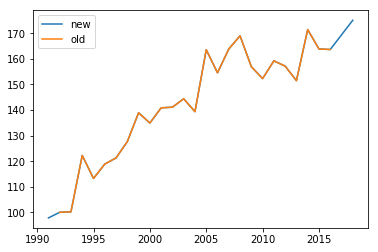

14098


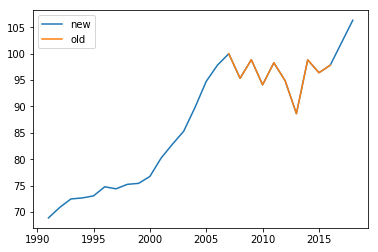

14561


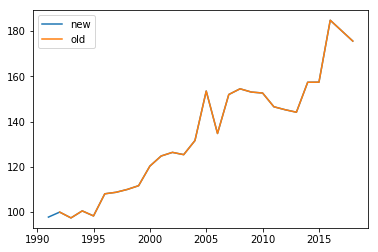

12075


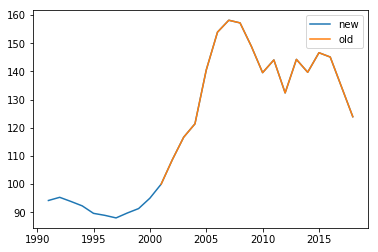

14572


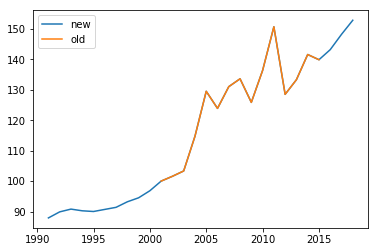

43718


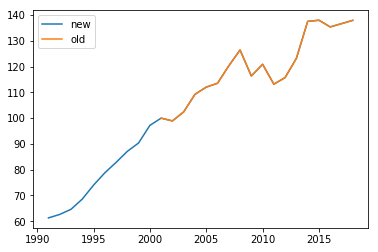

45812


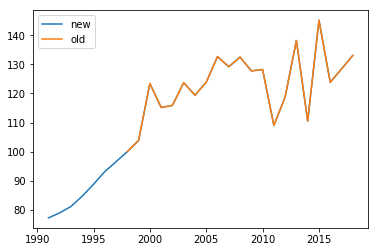

50468


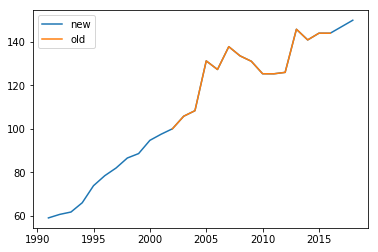

43009


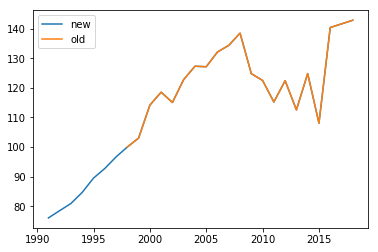

45317


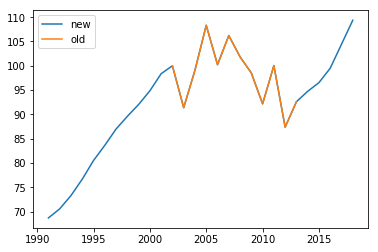

51601


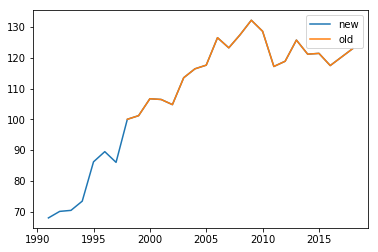

13733


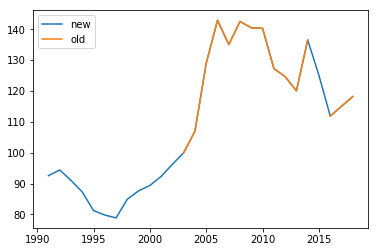

27983


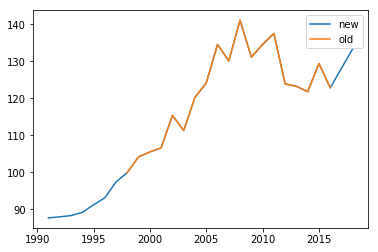

27571


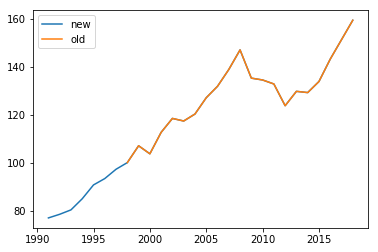

13350


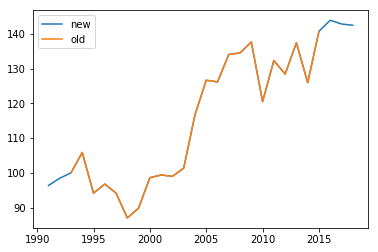

27024


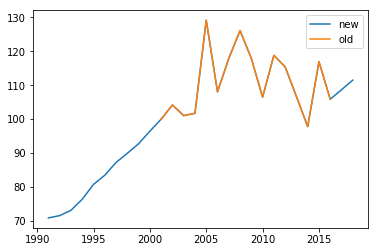

45034


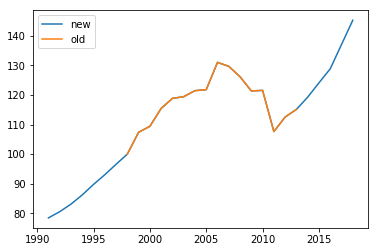

10964


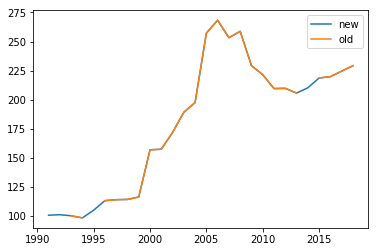

27810


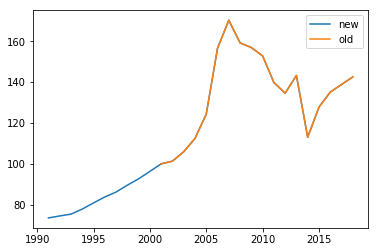

45831


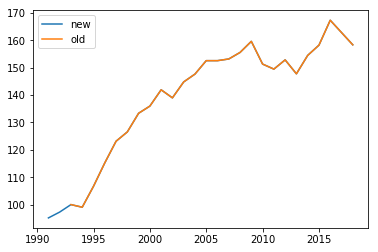

In [60]:
for i in  np.random.choice((new_pv_zip5_hpi)[pv_zip5_hpi.isnull().sum(1)>0].index,20):
    print i
    plt.plot(new_pv_zip5_hpi.loc[i])
    plt.plot(pv_zip5_hpi.loc[i])    
    plt.legend(['new','old'])
    plt.show()

In [61]:
new_pv_zip5_hpi.to_csv("../input/third2/HPI_AT_BDL_zip5_5state.csv")

### tract

In [62]:
%reset -f

In [63]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [64]:
pv_state5_hpi=pd.read_csv("../input/third2/HPI_AT_BDL_zip5_5state.csv", dtype={'zip5':np.str}).set_index("zip5")

In [65]:
def get_zip5_yearly_hpi(zip5,year):
    return pv_state5_hpi.loc[zip5,year]

In [66]:
def read_tract_to_zip5():
    zip_block=dd.read_parquet("../input/info/censusblockinfo_with_zip.parq").compute()
    a=zip_block[['zip','state']].drop_duplicates()
    assert a.groupby("zip").count().state.value_counts().shape[0]==1
    return dict(a.values)

In [67]:
#stop